In [ ]:
import numpy as np

In [ ]:
import pandas as pd

In [ ]:
from fractions import Fraction

In [ ]:
from queue import PriorityQueue

In [ ]:
from collections import deque

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Stride Scheduler

In [ ]:
def frac2float(frac):
  return frac.numerator / frac.denominator

In [ ]:
class StrideItem:
  def __init__(self, stride, name, share):
    self.stride = stride
    
    self.name = name
    self.share = share
    self.pass_value = self.stride.max_pass # Fraction(0)
    self.stride.all_share += self.share
  
  def process(self):
    self.pass_value += Fraction(self.stride.all_share, self.share)
    self.stride.max_pass = max(self.pass_value, self.stride.max_pass)
    return self
  
  def adjust(self, new_share):
    self.stride.all_share -= self.share
    self.share = new_share
    self.stride.all_share += self.share
    return self

  def __lt__(self, x):
    return self.pass_value < x.pass_value
  
  def __repr__(self):
    return f"{self.name}: share = {self.share}, pass = {self.pass_value}"

In [ ]:
class Stride:
  def __init__(self):
    self.all_share = 0
    self.max_pass = Fraction(0)
    self.sq = PriorityQueue()

    self.stride_logs = []
  
  def push(self, name, share):
    self.sq.put(StrideItem(self, name, share))

  def process(self):
    idx = 0
    while True:
      process = self.sq.get()
      self.stride_logs.append((idx, self.all_share, frac2float(self.max_pass), process.name, process.share, process.pass_value)) # logging
      yield process.process() # context switching
      self.sq.put(process)
      idx += 1

In [ ]:
sq = Stride()

In [ ]:
sq.push("Stride Process 0", 20)
sq.push("Stride Process 1", 10)
sq.push("Stride Process 2", 30)
sq.push("Stride Process 3", 20)
sq.push("Stride Process 4", 20)

In [ ]:
stride_scheduler = sq.process()

In [ ]:
for _ in range(50):
  item = next(stride_scheduler)

In [ ]:
item = next(stride_scheduler)
item.adjust(5)

Stride Process 3: share = 5, pass = 55

In [ ]:
for _ in range(50):
  item = next(stride_scheduler)

In [ ]:
sq.push("Stride Process 5", 30)
item = next(stride_scheduler)

In [ ]:
for _ in range(50):
  item = next(stride_scheduler)

In [ ]:
stride_df = pd.DataFrame(sq.stride_logs, columns=["ticks", "all_share", "max_pass", "name", "share", "pass_value"])
stride_df

,ticks,all_share,max_pass,name,share,pass_value
0,0,100,0.00,Stride Process 0,20,0
1,1,100,5.00,Stride Process 2,30,0
2,2,100,5.00,Stride Process 4,20,0
3,3,100,5.00,Stride Process 1,10,0
4,4,100,10.00,Stride Process 3,20,0
...,...,...,...,...,...,...
147,147,115,152.00,Stride Process 0,20,147
148,148,115,152.75,Stride Process 1,10,147
149,149,115,158.50,Stride Process 4,20,147
150,150,115,158.50,Stride Process 2,30,148


In [ ]:
stride_df["id"] = stride_df["name"].apply(lambda x: int(x[-1]))
stride_df

,ticks,all_share,max_pass,name,share,pass_value,id
0,0,100,0.00,Stride Process 0,20,0,0
1,1,100,5.00,Stride Process 2,30,0,2
2,2,100,5.00,Stride Process 4,20,0,4
3,3,100,5.00,Stride Process 1,10,0,1
4,4,100,10.00,Stride Process 3,20,0,3
...,...,...,...,...,...,...,...
147,147,115,152.00,Stride Process 0,20,147,0
148,148,115,152.75,Stride Process 1,10,147,1
149,149,115,158.50,Stride Process 4,20,147,4
150,150,115,158.50,Stride Process 2,30,148,2


In [ ]:
def plotStride(xlab="ticks", ylab="pass_value", figsize=(10, 10)):
  plt.figure(figsize=figsize)
  labels = list(stride_df["name"].unique())
  for label in labels:
    t = stride_df[stride_df["name"] == label]
    plt.scatter(t[xlab], t[ylab], alpha=0.7, label=label)
  plt.legend()
  plt.xlabel(xlab)
  plt.ylabel(ylab)

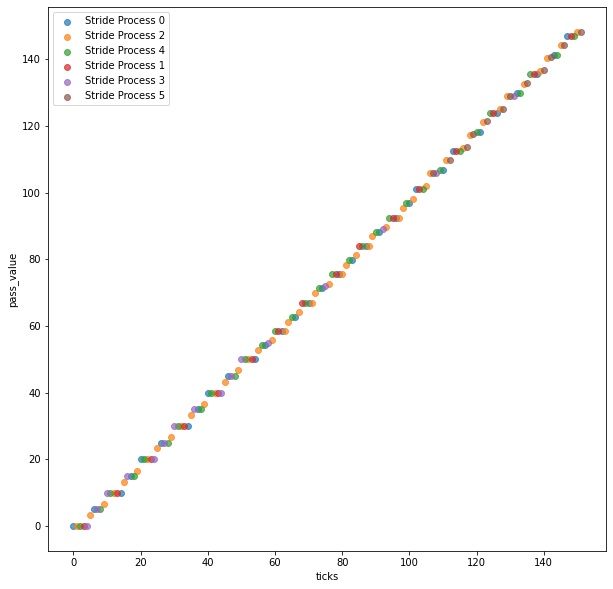

In [ ]:
plotStride()

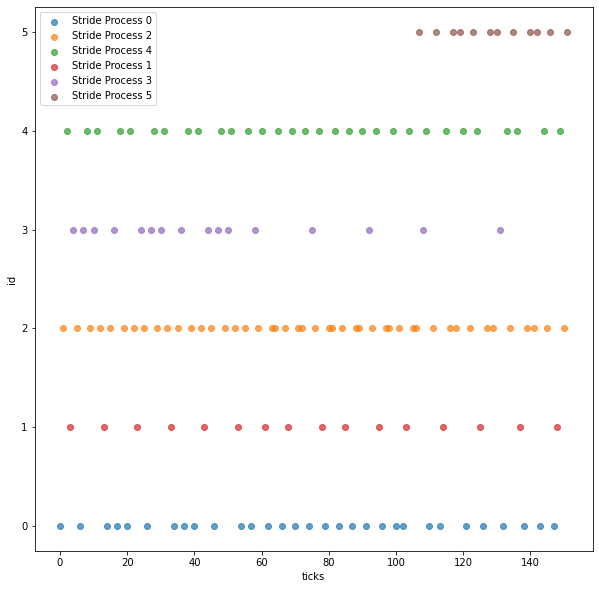

In [ ]:
plotStride(ylab="id")

# MLFQ

In [ ]:
class MLFQItem:
  def __init__(self, name):
    self.name = name
    self.ticks = 0
    self.reset()

  def process(self):
    self.ticks += 1
    self.cticks += 1
    return self

  def reset(self):
    self.cticks = 0
    return self

  def __repr__(self):
    return f"{self.name}: ticks = {self.ticks}, cticks = {self.cticks}"

In [ ]:
class MLFQ:
  def __init__(self, numQ = 3, boosting_ticks = 100, max_ticks = (1, 2, 4), time_allots = (5, 10, 10 ** 8)):
    self.numQ = numQ

    self.ticks_left = 0
    self.mlfq = [deque() for _ in range(self.numQ)]
    self.mlfq_ticks = 0

    self.max_ticks = max_ticks
    self.boosting_ticks = boosting_ticks
    self.time_allots = time_allots

    self.mlfq_logs = []

  def push(self, item):
    self.mlfq[0].append(item)
  
  def boost_priority(self):
    for mlfq in self.mlfq[1:]:
      if len(mlfq) == 0:
        continue
      def processResetAndReturn(p):
        p.reset()
        return p
      # print("Boosting Occurs")
      self.mlfq[0].extend(list(map(processResetAndReturn, list(mlfq))))
      mlfq.clear()
  
  def process(self):
    while True:
      for idx in range(self.numQ):
        if len(self.mlfq[idx]) == 0:
          continue
        
        process = self.mlfq[idx].popleft()

        for _ in range(self.max_ticks[idx]):
          self.mlfq_logs.append((self.mlfq_ticks, process.name, process.ticks, process.cticks, idx)) # logging
          
          yield process.process() # context switching
          self.mlfq_ticks +=1
          # print(f"{MLFQItem.ticks:04}: {process}, level = {idx}")

          if self.mlfq_ticks % self.boosting_ticks == self.boosting_ticks - 1:
            self.boost_priority()

        if process.cticks >= self.time_allots[idx]:
          process.reset() # Reset tick counts
          self.mlfq[min(idx+1, self.numQ-1)].append(process) # Lower
        else:
          self.mlfq[idx].append(process) # Stay the same level
        break

In [ ]:
BOOSTING_TICKS = 100
MLFQ_MAX_TICKS = [
  1, 2, 4
]
MLFQ_TIME_ALLOTS = [
  5, 10, 10 ** 8
]

In [ ]:
mlfq = MLFQ(3, BOOSTING_TICKS, MLFQ_MAX_TICKS, MLFQ_TIME_ALLOTS)

In [ ]:
mlfq.push(MLFQItem("MLFQ Process 0"))
mlfq.push(MLFQItem("MLFQ Process 1"))
mlfq.push(MLFQItem("MLFQ Process 2"))
mlfq.push(MLFQItem("MLFQ Process 3"))
mlfq.push(MLFQItem("MLFQ Process 4"))

In [ ]:
MLFQ_scheduler = mlfq.process()

In [ ]:
for _ in range(80):
  next(MLFQ_scheduler)

In [ ]:
mlfq.push(MLFQItem("MLFQ Process 5"))

In [ ]:
for _ in range(70):
  next(MLFQ_scheduler)

In [ ]:
mlfq_df = pd.DataFrame(mlfq.mlfq_logs, columns=["MLFQ_ticks", "process_name", "process_ticks", "queue_ticks", "level"])

In [ ]:
def plotMLFQ(xlab="MLFQ_ticks", ylab="process_ticks", figsize=(10, 10)):
  plt.figure(figsize=figsize)
  labels = list(mlfq_df["process_name"].unique())
  for label in labels:
    t = mlfq_df[mlfq_df["process_name"] == label]
    if ylab == "level":
      plt.scatter(t[xlab], 2-t["level"], alpha=0.7, label=label)
    else:
      plt.scatter(t[xlab], t[ylab], alpha=0.7, label=label)
  plt.legend()
  plt.xlabel("# of MLFQ ticks elapsed")
  plt.ylabel(ylab.replace("_", " "))

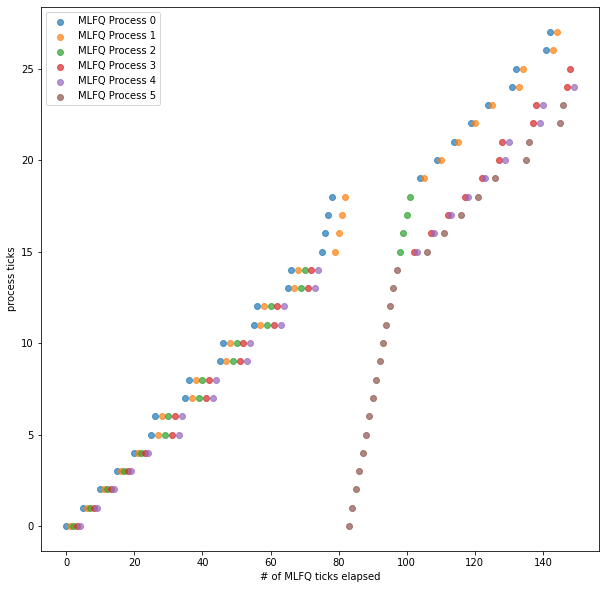

In [ ]:
plotMLFQ()

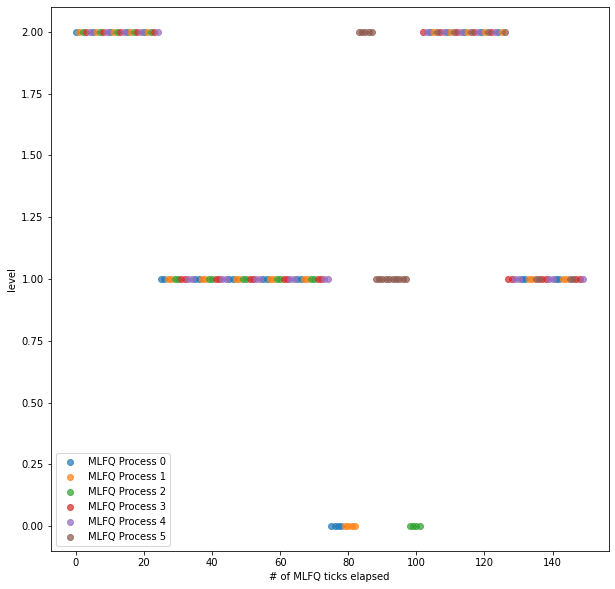

In [ ]:
plotMLFQ(ylab="level")

# MLFQ + Stride

In [ ]:
class MLFQStrideItem(StrideItem):
  def __init__(self, stride, mlfq, mlfq_scheduler):
    super().__init__(stride, "MLFQ", 20)
    self.mlfq = mlfq
    self.mlfq_scheduler = mlfq_scheduler
  
  def process_mlfq(self):
    return next(self.mlfq_scheduler)

In [ ]:
class StrideWithMLFQ:
  def __init__(self):
    self.all_share = 0
    self.max_pass = Fraction(0)
    self.sq = PriorityQueue()

    self.stride_logs = []
  
  def push(self, name, share):
    self.sq.put(StrideItem(self, name, share))
  
  def pushMLFQ(self, mlfq, mlfq_scheduler):
    self.sq.put(MLFQStrideItem(self, mlfq, mlfq_scheduler))

  def process(self):
    idx = 0
    while True:
      process = self.sq.get()
      if isinstance(process, MLFQStrideItem):
        for _ in range(4):
          mini_process = process.process_mlfq()
          self.stride_logs.append((idx, self.all_share, frac2float(self.max_pass), mini_process.name, process.share, process.pass_value)) # logging
          yield mini_process # context switching
          idx += 1
      else:
        for _ in range(4):
          self.stride_logs.append((idx, self.all_share, frac2float(self.max_pass), process.name, process.share, process.pass_value)) # logging
          yield process # context switching
          idx += 1
      process.process()
      self.sq.put(process)

In [ ]:
smlfq = StrideWithMLFQ()

In [ ]:
mlfq = MLFQ()

In [ ]:
mlfq.push(MLFQItem("MLFQ Process 0"))
mlfq.push(MLFQItem("MLFQ Process 1"))
mlfq.push(MLFQItem("MLFQ Process 2"))
mlfq.push(MLFQItem("MLFQ Process 3"))

In [ ]:
mlfq_scheduler = mlfq.process()

In [ ]:
smlfq.pushMLFQ(mlfq, mlfq_scheduler)

In [ ]:
smlfq.push("Stride Process 0", 1)
smlfq.push("Stride Process 1", 3)
smlfq.push("Stride Process 2", 4)

In [ ]:
smlfq_scheduler = smlfq.process()

In [ ]:
for _ in range(800):
  next(smlfq_scheduler)

In [ ]:
smlfq_df = pd.DataFrame(smlfq.stride_logs, columns = ["ticks", "all_share", "max_pass", "name", "share", "pass_value"])
smlfq_df["pass_value"] = smlfq_df["pass_value"].apply(frac2float)
smlfq_df

,ticks,all_share,max_pass,name,share,pass_value
0,0,28,0.000000,MLFQ Process 0,20,0.0
1,1,28,0.000000,MLFQ Process 1,20,0.0
2,2,28,0.000000,MLFQ Process 2,20,0.0
3,3,28,0.000000,MLFQ Process 3,20,0.0
4,4,28,1.400000,Stride Process 1,3,0.0
...,...,...,...,...,...,...
795,795,28,205.333333,MLFQ Process 0,20,196.0
796,796,28,205.333333,Stride Process 0,1,196.0
797,797,28,205.333333,Stride Process 0,1,196.0
798,798,28,205.333333,Stride Process 0,1,196.0


In [ ]:
len(smlfq_df[smlfq_df["name"].apply(lambda x:x[:4]) == "MLFQ"]) / len(smlfq_df["name"])

0.705

In [ ]:
len(smlfq_df[smlfq_df["name"] == "Stride Process 0"]) / len(smlfq_df["name"])

0.04

In [ ]:
len(smlfq_df[smlfq_df["name"] == "Stride Process 1"]) / len(smlfq_df["name"])

0.11

In [ ]:
len(smlfq_df[smlfq_df["name"] == "Stride Process 2"]) / len(smlfq_df["name"])

0.145

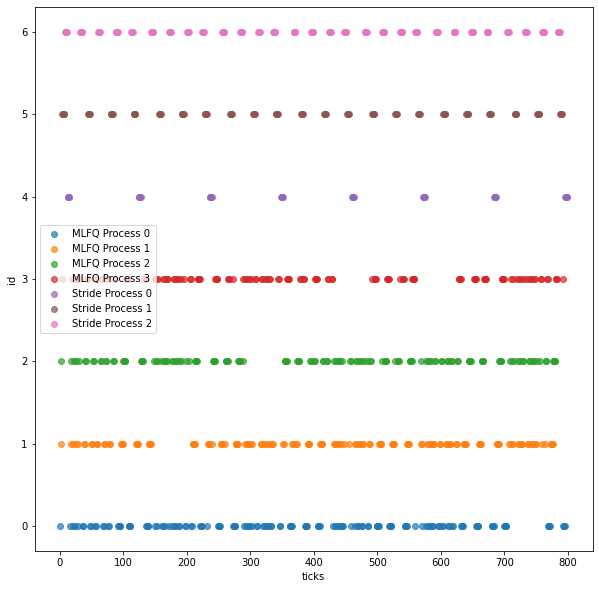

In [ ]:
if True:
  plt.figure(figsize=(10, 10))
  labels = list(smlfq_df["name"].unique())
  labels.sort()
  for label_idx, label in enumerate(labels):
    t = smlfq_df[smlfq_df["name"] == label]
    plt.scatter(t["ticks"], np.repeat(label_idx, len(t["ticks"])), alpha=0.7, label=label)
  plt.legend()
  plt.xlabel("ticks")
  plt.ylabel("id")